#WOMANIUM 2024 Project JMM Updates


We use the code from [Jarvis Tools Notebooks](https://github.com/JARVIS-Materials-Design/jarvis-tools-notebooks?tab=readme-ov-file#intro) and this [tutorial](https://forecastegy.com/posts/lightgbm-binary-classification-python/) to train and test our model supervised machine learning model LightGBM and retrieve our dataset. We realized that we were training on too many features so we attempt to reduce them by performing Principal Component Analysis that was inspired by this [hackathon submission](https://github.com/craftingweb/HackPrinceton/blob/main/pca_features.py).

## Preparing the data

In [2]:
!pip install jarvis-tools

In [3]:
from jarvis.db.figshare import data #retrieve data of materials
import pandas as pd #for data manipulation and creating dataframes which are like tables
df=pd.DataFrame(data('dft_3d')) #3d dataset includes geometric and visual properties

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


In [4]:
#Based on the Accelerated Discovery of Efficient Solar Cell Materials Using Quantum and Machine Learning Methods,
#we are interested in materials with SLME values > 10%
#remove the data that does not have SLME values
df_slme = df[df['slme'] != 'na'].copy()
#to compare the slme values we need to convert it to a float
df_slme['slme'] = df_slme['slme'].astype(float)
#add a new column slme_10 that has a 1 if slme value >=10.0 otherwise 0
df_slme['slme_10'] = (df_slme['slme'] >= 10.0).astype(int)
df_slme #display the data

,jid,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,atoms,slme,magmom_oszicar,...,poisson,raw_files,nat,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,reference,search,slme_10
20,JVASP-60702,61,Pbca,PdSe8Cl2,-0.15071,OptB88vdW,1.197,"{'lattice_mat': [[9.067075684180468, -0.0, 0.0...",32.60,0.0,...,na,"[DFPT,JVASP-60702.zip,https://ndownloader.figs...",44,na,na,na,na,mp-567437,-Cl-Pd-Se,1
23,JVASP-86436,148,R-3,LiSbF6,-2.61531,OptB88vdW,4.907,"{'lattice_mat': [[4.509029640475962, 0.0564034...",21.81,0.0,...,na,"[OPT-LOPTICS,JVASP-86436.zip,https://ndownload...",8,na,na,na,na,mp-3980,-F-Li-Sb,1
24,JVASP-1372,216,F-43m,AlAs,-0.57639,OptB88vdW,1.681,"{'lattice_mat': [[3.5058938597621094, -3.08124...",17.06,0.0,...,0.25,"[FD-ELAST,JVASP-1372.zip,https://ndownloader.f...",2,68.87,42.58,2.276,na,mp-2172,-Al-As,1
25,JVASP-14873,221,Pm-3m,SrB6,-0.49796,OptB88vdW,0.016,"{'lattice_mat': [[4.191262576674699, 0.0, -0.0...",6.11,0.0,...,0.2,"[FD-ELAST,JVASP-14873.zip,https://ndownloader....",7,150.6,125.7,0.256,na,mp-242,-B-Sr,0
26,JVASP-28397,53,Pmna,SiS,-0.38924,OptB88vdW,0.658,"{'lattice_mat': [[0.0, -3.9587610833154616, 0....",31.59,na,...,0.39,"[FD-ELAST,JVASP-28397.zip,https://ndownloader....",8,6.63,5.44,0.959,na,mp-1023900,-S-Si,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75345,JVASP-152501,88,I4_1/a,Li4HN,-0.56067,OptB88vdW,2.120,"{'lattice_mat': [[-2.4135795217419225, 2.41357...",2.94,0.0,...,na,[],12,na,na,3.183,na,auid-ac967cceb96b5f2b,-H-Li-N,0
75566,JVASP-156465,216,F-43m,PmCdGa,-0.44795,OptB88vdW,0.050,"{'lattice_mat': [[-0.0, 3.3728792894010553, 3....",5.84,0.0,...,na,[],3,na,na,0.113,na,953260,-Cd-Ga-Pm,0
75593,JVASP-156446,216,F-43m,HfInAu,-0.39541,OptB88vdW,0.441,"{'lattice_mat': [[0.0, 3.225842292903002, 3.22...",13.63,0.0,...,na,[],3,na,na,0.469,na,947461,-Au-Hf-In,1
75961,JVASP-156363,216,F-43m,HfPdPb,-0.42246,OptB88vdW,0.310,"{'lattice_mat': [[0.0, 3.218164909882003, 3.21...",5.84,0.0,...,na,[],3,na,na,0.278,na,897636,-Hf-Pb-Pd,0


In [5]:
# Getting shape of the df
shape = df.shape

# Printing Number of columns
print('Number of columns :', shape[1])

Number of columns : 64


In [6]:
#Drop the columns that are not categorical or numerical such as IDs or arrays
df_slme = df_slme.drop(columns=['jid', 'atoms', 'elastic_tensor', 'effective_masses_300K', 'modes', 'icsd','efg', 'xml_data_link', 'raw_files', 'reference', 'search'])


In [7]:
#replace na with NaN
import numpy as np
df_slme.replace('na', np.nan,  inplace=True)


C:\Users\nitro\AppData\Local\Temp\ipykernel_60344\3771167460.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_slme.replace('na', np.nan,  inplace=True)


In [8]:
#convert columns as int/float/boolean as appropriate. This is important for when we train our model

col_convert_float = [ 'magmom_oszicar', 'spillage', 'maxdiff_mesh', 'maxdiff_bz', 'epsx', 'epsy', 'epsz',
    'mepsx', 'mepsy', 'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
    'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
    'dfpt_piezo_max_dielectric_electronic', 'dfpt_piezo_max_dielectric_ionic',
    'max_ir_mode', 'min_ir_mode', 'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact',
    'ncond', 'pcond', 'nkappa', 'pkappa', 'Tc_supercon', 'exfoliation_energy', 'poisson',
    'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap']

for col_name in col_convert_float:
    df_slme.loc[:,col_name] = df_slme[col_name].astype(float)


df_slme.loc[:,'encut'] = df_slme['encut'].fillna(0).astype(int)
df_slme.loc[:,'kpoint_length_unit'] = df_slme['kpoint_length_unit'].fillna(0).astype(int)

# Principal Component Analysis
## What is PCA?
- unsupervised learning algorithm technique to reduce the input features while retaining as much of the original data.
- It uses an [orthogonal transformation that converts a set of correlated variables to a set of *uncorrelated* variables](https://www.geeksforgeeks.org/principal-component-analysis-pca/). This makes it easier to understand what each variable represents for continuous variables.
- [In depth explanation of PCA](https://www.youtube.com/watch?v=_UVHneBUBW0)

## Why do PCA?
- We have too many features which can lead to overfitting and increased computation time. [As the number of dimensions increase, the number of possible combinations of features increases](https://www.geeksforgeeks.org/principal-component-analysis-pca/).

In [9]:
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

### 1. Standardize the features

This means that each variable has a mean of 0 and standard deviation of 1. This is done by subtracting the mean and dividing it by the standard deviation. We are changing the mean and standard deviation to a standard normal distribution.

$$z = (value - mean) / standard deviation$$


Why do we standardize features?

It handles highly varying magnitudes/values/units. It prevents features from dominating other features when we train the model because some features may have larger values than others which will allow it to give more contribution to the distance computation. [For example, we a have 2 dimensional data set with height in meters and weight in pounds, with ranges 1-2 meters and 10 to 200 lbs respectively, then the weight will contribute more just because it has larger values](https://builtin.com/data-science/when-and-why-standardize-your-data)

In [10]:
#save target and original columns remove target label for pca
target_pca = df_slme["slme_10"]
df_pca = df_slme.select_dtypes(include = ['number']).drop(columns=['slme_10', 'slme'])


In [11]:
#save original columns
original_columns = df_pca.columns

In [12]:
print(df_pca.columns)

Index(['formation_energy_peratom', 'optb88vdw_bandgap', 'magmom_oszicar',
       'spillage', 'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut',
       'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy',
       'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
       'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon',
       'exfoliation_energy', 'density', 'poisson', 'nat', 'bulk_modulus_kv',
       'shear_modulus_gv', 'mbj_bandgap', 'hse_gap'],
      dtype='object')


In [13]:
imputer = SimpleImputer(strategy='mean')
df_pca = imputer.fit_transform(df_pca)

In [14]:
#Standardize features
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_pca)

In [15]:
#Select number of components we want - MARIA How do we determine number of principal components

pca_list = []
components_test = 2

#Determine number of components that guarantees variance of at least 0.95
for i in range(2,df_pca.shape[1]):
  pca_test= PCA(n_components = i)
  pca_test.fit(df_pca_scaled)
  pca_list.append(pca_test)
  if (sum(pca_test.explained_variance_ratio_) > 0.95):
    break

#Determine the minimum number of components that guarantees variance of at least 0.95
print("Min Components for at least 95% Variance:", len(pca_list)+1)

#Set PCA Object to the ideal amount of components
pca = pca_list[-1]



Min Components for at least 95% Variance: 30


In [44]:
#Transform the the scaled dataset
df_pca_transformed = pca.transform(df_pca_scaled)
print("Shape of PCA transformed data:", df_pca_transformed.shape)

Shape of PCA transformed data: (9770, 30)


In [17]:
components_df = pd.DataFrame(
    pca.components_,
    columns = original_columns, #columns of original table of features
    index = [f"PC{i+1}" for i in range(pca.n_components_)] #creates an index for each component
)
print(components_df)

      formation_energy_peratom  optb88vdw_bandgap  magmom_oszicar  spillage  \
PC1                   0.144165          -0.229158        0.057707  0.088481   
PC2                  -0.094035           0.113486       -0.042899 -0.025794   
PC3                   0.310548          -0.203080       -0.081453 -0.026641   
PC4                   0.021396          -0.140685       -0.200749 -0.097197   
PC5                   0.024633           0.130881       -0.125324 -0.105336   
PC6                  -0.017631          -0.163492        0.482242 -0.139471   
PC7                  -0.073322          -0.114701        0.273890 -0.165986   
PC8                   0.066025           0.066630        0.249359  0.068902   
PC9                   0.131930           0.145169        0.077202  0.038663   
PC10                  0.210021          -0.271499       -0.078981 -0.067856   
PC11                  0.243979          -0.041279       -0.050797 -0.026043   
PC12                 -0.047719           0.091025   

In [18]:
# Sum the absolute contributions for each feature across all  components
importance = components_df.abs().sum(axis=0)
print(importance.shape)

(44,)


In [19]:
#sort the features based on their total importance
sorted_importance = importance.sort_values(ascending = False)
print(sorted_importance)

density                                 3.974521
ehull                                   3.921480
n-Seebeck                               3.802599
spillage                                3.802420
dfpt_piezo_max_dij                      3.774474
nat                                     3.769979
max_ir_mode                             3.714531
min_ir_mode                             3.701741
max_efg                                 3.693733
p-powerfact                             3.659485
kpoint_length_unit                      3.656057
dfpt_piezo_max_dielectric_ionic         3.643756
dfpt_piezo_max_eij                      3.639427
encut                                   3.508522
dfpt_piezo_max_dielectric               3.506056
n-powerfact                             3.426714
hse_gap                                 3.390229
formation_energy_peratom                3.382341
dfpt_piezo_max_dielectric_electronic    3.374462
avg_elec_mass                           3.310744
mbj_bandgap         

In [20]:
#sucessive variance explained by each component
print(pca.explained_variance_ratio_)

[0.16482332 0.08695338 0.06756401 0.05317042 0.0438773  0.03960964
 0.03883108 0.03457844 0.03251941 0.03069952 0.02634012 0.02561844
 0.02336397 0.02281124 0.02266727 0.02249789 0.02180939 0.02143171
 0.02089786 0.01979623 0.01754344 0.01726841 0.01598956 0.01510678
 0.01422683 0.0138157  0.01200918 0.01071671 0.00998443 0.00972394]


In [21]:
#table of principal components
df_pca1 = pd.DataFrame(
    df_pca_transformed,
    columns=['PC{}'.format(i+1)
              for i in range(pca.n_components_)]
)
print(df_pca1)

           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1.298875 -0.133382  0.007173 -1.136199  2.366456  0.621573 -0.237534   
1    -1.325241  0.538102 -0.599072 -0.336852  0.126583 -0.447480 -0.188308   
2     0.971039 -0.427187  1.308791  2.262430 -0.716833 -0.476069 -0.200478   
3     1.773288 -0.063504 -0.940709  1.207446 -3.351197 -0.402269  0.641771   
4    -0.196506 -0.166568  2.602785 -0.900764  0.233076  0.440495  0.548308   
...        ...       ...       ...       ...       ...       ...       ...   
9765 -0.400054  0.012355  0.841995 -0.353993  0.031211 -0.058483 -0.109633   
9766  8.761058 -2.806388 -1.691015 -0.290665  3.816012 -0.435133 -1.174776   
9767  3.289793 -1.138500  0.147366  1.466655  0.809232 -0.009199  0.114194   
9768  3.387488 -1.151186 -0.096001  1.542707  0.810518  0.039217  0.116416   
9769  1.759567 -0.532938  1.056678 -1.228156  1.203294 -0.644662 -0.471079   

           PC8       PC9      PC10  ...      PC21      PC22    

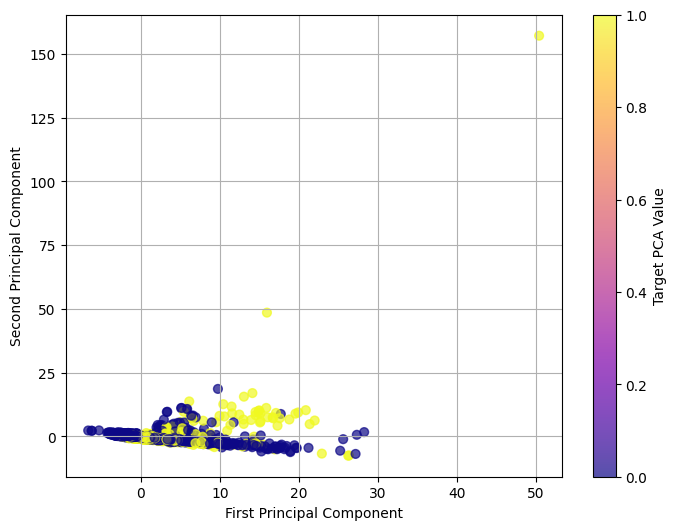

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Create the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_pca_transformed[:,0],
    df_pca_transformed[:,1],
    c=target_pca,
    cmap='plasma',
    alpha=0.7,  # Adjust transparency to visualize overlap
    s=40        # Size of points
)


# Label x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Add a colorbar directly linked to the scatter plot
cbar = plt.colorbar(scatter)  # Pass the scatter plot object
cbar.set_label('Target PCA Value')  # Label for the colorbar

plt.grid(True)
plt.show()


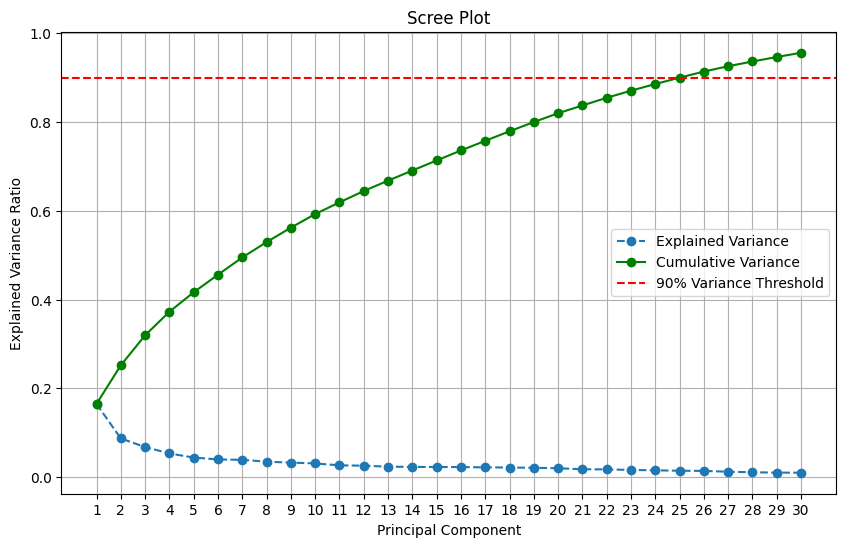

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assume `pca` is the trained PCA object
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(explained_variance_ratio) + 1),  # X-axis is component index
    explained_variance_ratio,
    marker='o', linestyle='--', label='Explained Variance'
)

# Cumulative variance
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(
    np.arange(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o', linestyle='-', color='green', label='Cumulative Variance'
)

# Add labels, title, and legend
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))  # Add all component numbers as ticks
plt.axhline(y=0.9, color='red', linestyle='--', label='90% Variance Threshold')  # Optional threshold
plt.legend()
plt.grid(True)
plt.show()

# Principal Component Analysis with 3 (TO DO)



#LightGBM Supervised Machine Learning Model

 This model is a binary classifier that will help us decide whether a material is potentially suitable or not for Photovoltaic cells. The criteria for creating the dataset was based on the paper on [Accelerated Discovery of Efficient Solar Cell Materials Using Quantum and Machine-Learning Methods](https://pubs.acs.org/doi/full/10.1021/acs.chemmater.9b02166)

In [24]:
#convert columns as int/float/boolean as appropriate. This is important for when we train our model

col_convert_float = [ 'magmom_oszicar', 'spillage', 'maxdiff_mesh', 'maxdiff_bz', 'epsx', 'epsy', 'epsz',
    'mepsx', 'mepsy', 'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
    'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
    'dfpt_piezo_max_dielectric_electronic', 'dfpt_piezo_max_dielectric_ionic',
    'max_ir_mode', 'min_ir_mode', 'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact',
    'ncond', 'pcond', 'nkappa', 'pkappa', 'Tc_supercon', 'exfoliation_energy', 'poisson',
    'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap']

for col_name in col_convert_float:
    df_slme.loc[:,col_name] = df_slme[col_name].astype(float)


df_slme.loc[:,'encut'] = df_slme['encut'].fillna(0).astype(int)
df_slme.loc[:,'kpoint_length_unit'] = df_slme['kpoint_length_unit'].fillna(0).astype(int)

In [25]:
#display table to see table with cleaned values
df_slme

,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,slme,magmom_oszicar,spillage,kpoint_length_unit,...,spg,crys,density,poisson,nat,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,slme_10
20,61,Pbca,PdSe8Cl2,-0.15071,OptB88vdW,1.197,32.60,0.0,NaN,35.0,...,61,orthorhombic,4.471,NaN,44,NaN,NaN,NaN,NaN,1
23,148,R-3,LiSbF6,-2.61531,OptB88vdW,4.907,21.81,0.0,NaN,20.0,...,148,trigonal,3.997,NaN,8,NaN,NaN,NaN,NaN,1
24,216,F-43m,AlAs,-0.57639,OptB88vdW,1.681,17.06,0.0,NaN,30.0,...,216,cubic,3.607,0.25,2,68.87,42.58,2.276,NaN,1
25,221,Pm-3m,SrB6,-0.49796,OptB88vdW,0.016,6.11,0.0,NaN,30.0,...,221,cubic,3.439,0.20,7,150.60,125.70,0.256,NaN,0
26,53,Pmna,SiS,-0.38924,OptB88vdW,0.658,31.59,NaN,NaN,40.0,...,53,orthorhombic,0.633,0.39,8,6.63,5.44,0.959,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75345,88,I4_1/a,Li4HN,-0.56067,OptB88vdW,2.120,2.94,0.0,NaN,20.0,...,88,tetragonal,1.237,NaN,12,NaN,NaN,3.183,NaN,0
75566,216,F-43m,PmCdGa,-0.44795,OptB88vdW,0.050,5.84,0.0,NaN,40.0,...,216,cubic,7.079,NaN,3,NaN,NaN,0.113,NaN,0
75593,216,F-43m,HfInAu,-0.39541,OptB88vdW,0.441,13.63,0.0,NaN,35.0,...,216,cubic,12.126,NaN,3,NaN,NaN,0.469,NaN,1
75961,216,F-43m,HfPdPb,-0.42246,OptB88vdW,0.310,5.84,0.0,NaN,35.0,...,216,cubic,12.259,NaN,3,NaN,NaN,0.278,NaN,0


In [26]:
#this code was used to investigate the values in each column
#pd.set_option('display.max_rows',None)
#print(df_slme['search'])

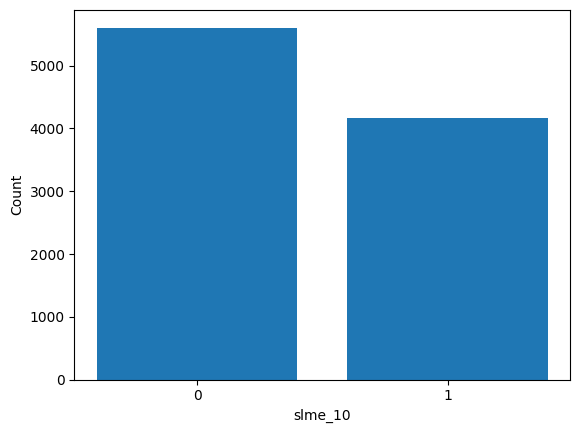

In [27]:
#check if the data is imbalanced this means if there are more 1s and 0s or vice versa
import matplotlib.pyplot as plt
%matplotlib inline
check_imbalance = df_slme['slme_10'].value_counts().reset_index()
check_imbalance.columns = ['slme_10', 'count']

# Create the bar plot using matplotlib
plt.bar(check_imbalance['slme_10'], check_imbalance['count'])
plt.xlabel('slme_10')
plt.ylabel('Count')
plt.xticks(check_imbalance['slme_10'])
plt.show()

# Split the data into training and test

In [28]:
df_slme.columns

Index(['spg_number', 'spg_symbol', 'formula', 'formation_energy_peratom',
       'func', 'optb88vdw_bandgap', 'slme', 'magmom_oszicar', 'spillage',
       'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut',
       'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy',
       'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
       'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality',
       'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'nat',
       'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap',
       'slme_10'],
      dtype='object')

In [46]:
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
#features is what the model will use to predict the target variable, slme_10
print(df_slme.columns)
features = df_slme.drop(columns=['slme_10','slme', 'formula'])
target = df_slme['slme_10']

#test dataset size is 20% and traing dataset is 80% (random_state is the seed so thatt chooses random materials to put in training nad testing data set)
random.seed(datetime.now().timestamp())
random_num = random.randint(1,100)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=random_num)

#get the indices of the test values so we can retrieve the material's formula later
test_indices = features_test.index


Index(['spg_number', 'spg_symbol', 'formula', 'formation_energy_peratom',
       'func', 'optb88vdw_bandgap', 'slme', 'magmom_oszicar', 'spillage',
       'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut',
       'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy',
       'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
       'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality',
       'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'nat',
       'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap',
       'slme_10'],
      dtype='object')


In [30]:
#make sure that we don't train with slme_10 and slme bychecking the columns
features.columns

Index(['spg_number', 'spg_symbol', 'formation_energy_peratom', 'func',
       'optb88vdw_bandgap', 'magmom_oszicar', 'spillage', 'kpoint_length_unit',
       'maxdiff_mesh', 'maxdiff_bz', 'encut', 'optb88vdw_total_energy', 'epsx',
       'epsy', 'epsz', 'mepsx', 'mepsy', 'mepsz', 'magmom_outcar', 'max_efg',
       'avg_elec_mass', 'avg_hole_mass', 'dfpt_piezo_max_eij',
       'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality',
       'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'nat',
       'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap'],
      dtype='object')

In [31]:
!pip install category_encoders

In [ ]:
#convert categorical data into integers
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['spg_number', 'spg_symbol', 'func', 'dimensionality', 'spg', 'crys', 'typ'])
features_train = encoder.fit_transform(features_train)
features_test = encoder.fit_transform(features_test)
categorical_df = features.select_dtypes(include=['object'])


<class 'pandas.core.frame.DataFrame'>


In [33]:
#make sure that there we raplace missing values with NaNs
features_train = features_train.replace('?', np.nan)
features_test = features_test.replace('?', np.nan)


## Setting the classfier model hyperparameters and training

In [34]:
from lightgbm import LGBMClassifier
# learning rate = how much each tree contributes to the overall predicition. The lower learning rate is better but takes longer training time
#n_estimators = number of trees to build. Higher value means longer training time
#num_leaves= number of leaves in each tree. Higher value means a less regularized model which can lead to overfitting
#verbose prevents the model from displaying warnings
#hyperparameters from the paper mentioned above
model = LGBMClassifier(learning_rate=0.01, n_estimators=5000, num_leaves=100, max_depth=30, boosting_type='gbdt', min_child_samples = 20, min_child_weight = 0.001, min_split_gain=0.0, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0, subsample_for_bin=200000,subsample_freq=1, verbose = -1)



In [35]:
model.fit(features_train, target_train, categorical_feature=['spg_number', 'spg_symbol', 'func', 'dimensionality', 'spg', 'crys', 'typ'])

,boosting_type,'gbdt'
,num_leaves,100
,max_depth,30
,learning_rate,0.01
,n_estimators,5000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Make predictions

In [36]:
#this directly predicts the class for each instance in the test set. the threshold of 0.5 fpr predicted probabilities
pred = model.predict(features_test)

In [37]:
#these are predicted probabilities rather than class predictions
pred_probabilities = model.predict_proba(features_test)[:,1]

In [38]:
#create dataframe to show which materials are suitable or not. This is mapping formulas back to the indices we save earlier

predictions_df = pd.DataFrame({ 'formula' : df_slme.loc[test_indices, 'formula'],
                               'predictions': pred })
print(predictions_df)
print("number of test values predicted: ", len(predictions_df))
print("number of potential materials: ", predictions_df['predictions'].sum())


         formula  predictions
17578  Rb2IrAuF6            1
23011   Rb2TeBr6            1
25596     NaDyO2            0
608      BaTm2O4            0
54634       CaNO            1
...          ...          ...
1683        TiO2            0
22688       CuBr            1
39752       SCl2            0
44936  Rb2NaNdF6            0
5436     BaZnCl2            1

[1954 rows x 2 columns]
number of test values predicted:  1954
number of potential materials:  830


# Evaluate the model

Note that the following values used to evaluate the model will vary every time we run all of the cells above because we choose random values for what is included in our testing and training dataset. However, the values should be similar.

In [39]:
#accuracy is one metric. It is the proportion of predictions that the mode got right. Number closer to 1 is good
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(target_test, pred)
print("Accuracy", accuracy )

Accuracy 0.9856704196519959


In [40]:
#log loss is another metric that evaluates the predicted probabilities of membership to a given class. Number closer to 0 is good
from sklearn.metrics import log_loss
loss = log_loss(target_test, pred_probabilities)
print("Log Loss", loss)


Log Loss 0.07524757905491015


In [41]:
#ROC AUC (Area under the ROC curve- Receiver operating characteristic curve: this curve plots the possible true positive rates agains false positive rates) score
#it is an aggregate measure of performance across all possible classification thresholds. Number closer to 1 is good
from sklearn.metrics import roc_auc_score
roc = roc_auc_score(target_test, pred)
print("ROC AUC ", roc)

ROC AUC  0.9850505310037685


In [42]:
#general classification report
from sklearn.metrics import classification_report
report = classification_report(target_test, pred)
print("Classification Report")
print(report)

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1120
           1       0.99      0.98      0.98       834

    accuracy                           0.99      1954
   macro avg       0.99      0.99      0.99      1954
weighted avg       0.99      0.99      0.99      1954



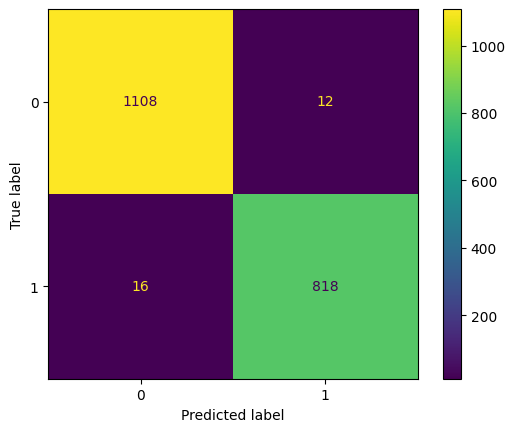

In [43]:
#confusion matrix to summarize performance of a classification model on a set of data where true values are known
from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay.from_predictions(target_test,pred)
plt.show()